# SODA 3.4.2 Data
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [32]:
client.close()
cluster.close()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.2fef9eef3d00463fba7e56a3483dc6b2/status,


In [5]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import xmitgcm
import xgcm
import json

In [8]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem(requester_pays=True)
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)#, decode_times=False)
#with fs.open('gs://pangeo-tmp/stb2145/SODA/datasets/topog.nc') as fp:
#    topo = xr.open_dataset(fp)

In [9]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

## <font color='Green'>Slice to WG region</font>

In [10]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [11]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_top = dict(grid_y_T=slice(lower_lat, upper_lat))
lon_range_top = dict(grid_x_T=slice(left_lon, right_lon))

In [12]:
ds_wg = ocean.isel(**lat_range, **lon_range)
#depth_wg = topo.depth.isel(**lat_range_top, **lon_range_top)

In [15]:
#have to give the 2 endpts same date for avging to work and keep the 12-24 timestamp
salt19 = ds_wg.salt.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
salt29 = ds_wg.salt.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

temp19 = ds_wg.temp.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
temp29 = ds_wg.temp.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

In [16]:
#avging the two endpts to insert onto 12-24 date instead of it being 0 (will help solve spike in timeseries)
salt24_ds = (salt19+salt29)/2
salt24 = salt24_ds.salt

temp24_ds = (temp19+temp29)/2
temp24 = temp24_ds.temp

In [18]:
#inserting avged salt/temp values on 12-24 date into ds_wg
ds_wg['salt'][1897] = salt24[0]
ds_wg['temp'][1897] = temp24[0]

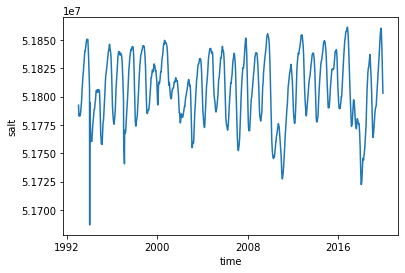

In [22]:
ds_wg.salt.sum(['st_ocean', 'yt_ocean', 'xt_ocean']).plot()

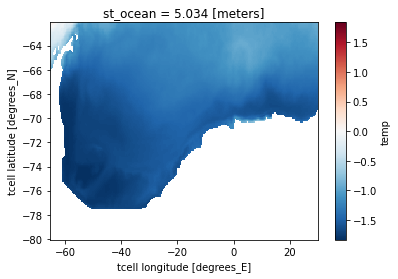

In [23]:
#testing to see if correctly sliced desired region
sst_mean = ds_wg.temp.isel(st_ocean=0).mean(dim='time')
sst_mean.plot()

## <span style='color:Red'> Bottom Potential Temperatures

In [24]:
#999 is ocean, 111 is land
hfacc = ds_wg.temp.where(ds_wg.temp == ds_wg.temp.notnull(), 999).where(ds_wg.temp < 999, 111)

In [25]:
hfacc

,Array,Chunk
Bytes,23.63 GiB,12.28 MiB
Shape,"(1970, 50, 169, 381)","(1, 50, 169, 381)"
Count,21677 Tasks,1970 Chunks
Type,float32,numpy.ndarray


In [26]:
#999 is ocean, 111 is land
depth_max = (ds_wg.st_ocean.where(hfacc == 999)).max(dim='st_ocean').load()

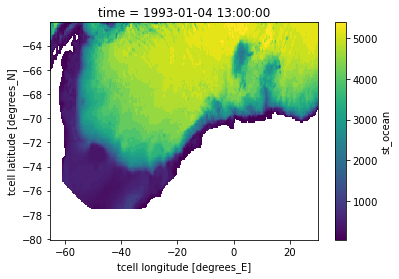

In [27]:
depth_max[0].plot()

In [28]:
depth_surf = (ds_wg.st_ocean.where(hfacc == 999)).min(dim='st_ocean').load()

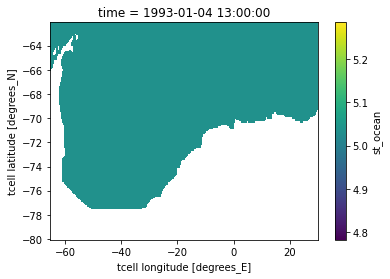

In [29]:
depth_surf[0].plot()

In [30]:
hfacc_file = depth_surf.to_dataset(name='hfacc')

In [31]:
hfacc_file

<xarray.Dataset>
Dimensions:   (time: 1970, xt_ocean: 381, yt_ocean: 169)
Coordinates:
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
Data variables:
    hfacc     (time, yt_ocean, xt_ocean) float64 nan nan nan ... 5.034 5.034

In [32]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcsfs_w_token = gcsfs.GCSFileSystem(token=token)

In [33]:
#uploading hfacc 
gcsmap_hfacc = gcsfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/hfacc.zarr')
hfacc_file.to_zarr(gcsmap_hfacc, mode='w')

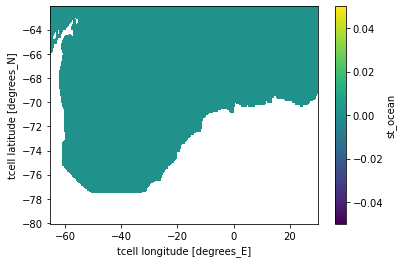

In [34]:
#depth doesn't change in time
depth_max.std(dim='time').plot()

In [35]:
depth_max = depth_max[0]

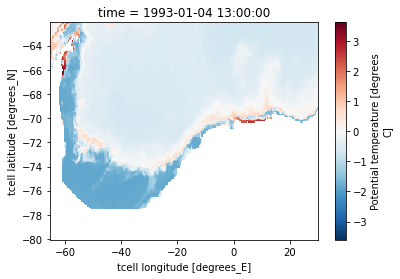

In [36]:
ds_wg.temp[0].sel(st_ocean=depth_max, method='nearest').plot()

In [37]:
temp_mean = ds_wg.temp.mean(dim='time').load()

In [38]:
bottom_temp = temp_mean.sel(st_ocean=depth_max, method='nearest')

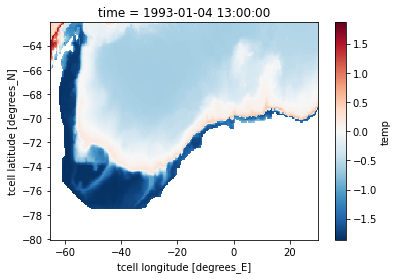

In [39]:
bottom_temp.plot()

In [40]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


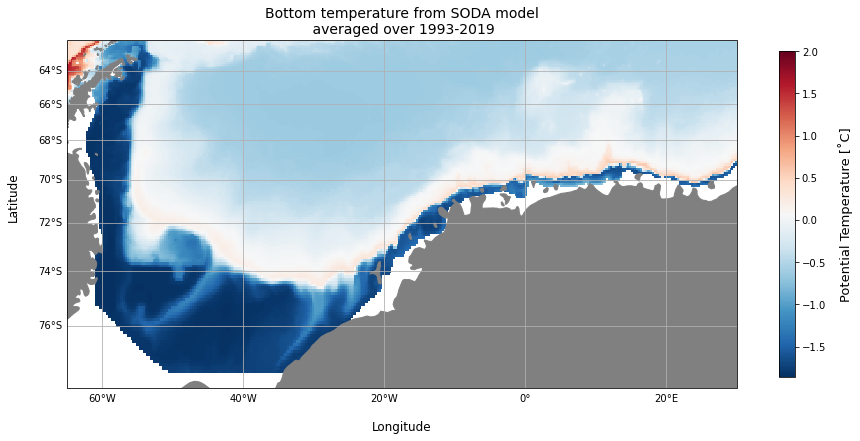

In [41]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_temp, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from SODA model\n averaged over 1993-2019', fontsize=14);

In [96]:
swap = bottom_temp.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})

In [100]:
bottom_temp = swap.assign_coords({"lon": swap.lon, 'lat':swap.lat}).drop(['xt_ocean', 'yt_ocean'])

In [101]:
bottom_temp

<xarray.DataArray 'temp' (lat: 169, lon: 381)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.3852743 ,  0.38618386,  0.38927206, ..., -0.5519045 ,
        -0.55108154, -0.54997754],
       [ 0.3911812 ,  0.3939399 ,  0.46547386, ..., -0.55275756,
        -0.5521167 , -0.55140436],
       [ 0.39906168,  0.4294568 ,  0.4476148 , ..., -0.5536591 ,
        -0.5535721 , -0.553762  ]], dtype=float32)
Coordinates:
    st_ocean  (lat, lon) float64 5.395e+03 5.395e+03 ... 5.185e+03 5.185e+03
    time      object 1993-01-04 13:00:00
  * lon       (lon) int64 0 1 2 3 4 5 6 7 8 ... 373 374 375 376 377 378 379 380
  * lat       (lat) int64 0 1 2 3 4 5 6 7 8 ... 161 162 163 164 165 166 167 168

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [42]:
temp_std = ds_wg.temp.std(dim='time').load()

In [90]:
bottom_temp_std = temp_std.sel(st_ocean=depth_max, method='nearest')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


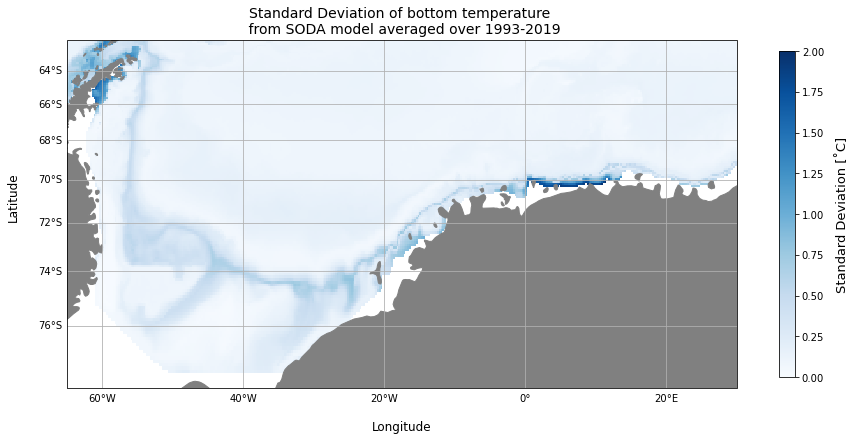

In [65]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_temp_std, transform=ccrs.PlateCarree(), cmap='Blues', vmin=0, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation of bottom temperature \n from SODA model averaged over 1993-2019', fontsize=14);

In [91]:
swap_dim = bottom_temp_std.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})

In [93]:
bottom_temp_std = swap_dim.assign_coords({"lon": swap_dim.lon, 'lat':swap_dim.lat}).drop(['xt_ocean', 'yt_ocean'])

In [94]:
bottom_temp_std

<xarray.DataArray 'temp' (lat: 169, lon: 381)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.12278862, 0.12426041, 0.1233142 , ..., 0.09295084, 0.09375399,
        0.09471092],
       [0.11924453, 0.12078746, 0.13167919, ..., 0.09136298, 0.09170933,
        0.09243467],
       [0.11351789, 0.11853682, 0.12957923, ..., 0.0896869 , 0.0889594 ,
        0.08804645]], dtype=float32)
Coordinates:
    st_ocean  (lat, lon) float64 5.395e+03 5.395e+03 ... 5.185e+03 5.185e+03
    time      object 1993-01-04 13:00:00
  * lon       (lon) int64 0 1 2 3 4 5 6 7 8 ... 373 374 375 376 377 378 379 380
  * lat       (lat) int64 0 1 2 3 4 5 6 7 8 ... 161 162 163 164 165 166 167 168

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity

In [45]:
#999 is ocean, 111 is land
hfacc_salt = ds_wg.salt.where(ds_wg.salt == ds_wg.salt.notnull(), 999).where(ds_wg.salt < 999, 111)

In [46]:
#999 is ocean, 111 is land
depth_max_salt = (ds_wg.st_ocean.where(hfacc_salt == 999)).max(dim='st_ocean').load()

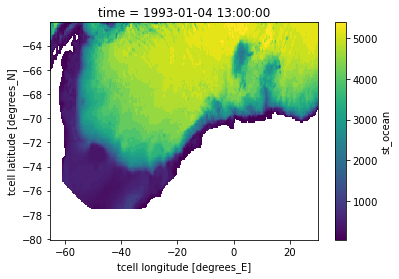

In [47]:
depth_max_salt[0].plot()

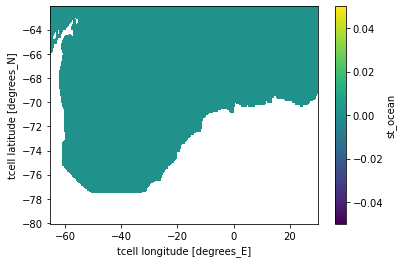

In [48]:
#depth doesn't change in time
depth_max_salt.std(dim='time').plot()

In [49]:
depth_max_salt = depth_max_salt[0]

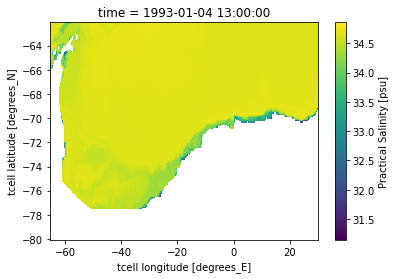

In [50]:
salt_mask[0].sel(st_ocean=depth_max_salt, method='nearest').plot()

In [51]:
salt_mean = salt_mask.mean(dim='time').load()

In [52]:
bottom_salt = salt_mean.sel(st_ocean=depth_max_salt, method='nearest')

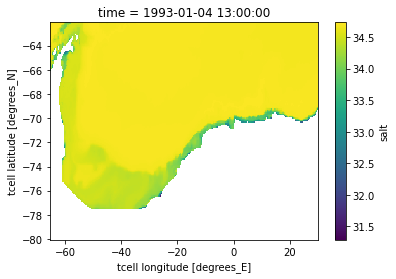

In [53]:
bottom_salt.plot()

In [54]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


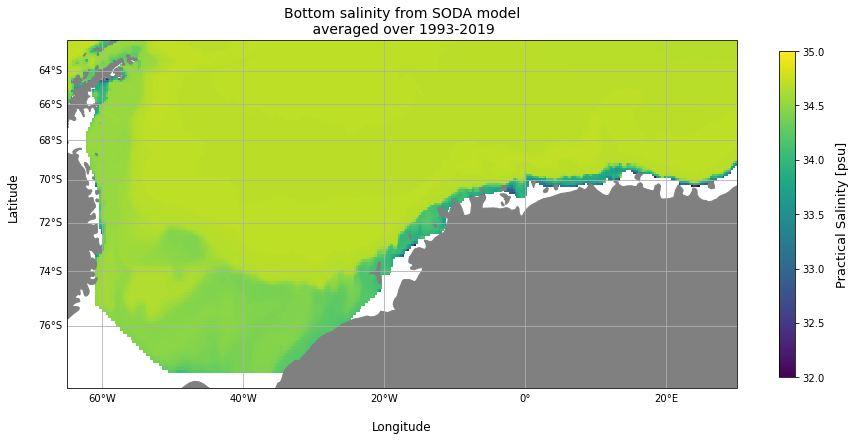

In [58]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_salt, transform=ccrs.PlateCarree(), cmap='viridis', vmin=32, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from SODA model\n averaged over 1993-2019', fontsize=14);

In [104]:
swap_slt = bottom_salt.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})

In [105]:
bottom_salt = swap_slt.assign_coords({"lon": swap_slt.lon, 'lat':swap_slt.lat}).drop(['xt_ocean', 'yt_ocean'])

In [106]:
bottom_salt

<xarray.DataArray 'salt' (lat: 169, lon: 381)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [34.722504, 34.722607, 34.722603, ..., 34.6698  , 34.669884,
        34.67004 ],
       [34.72252 , 34.722622, 34.72168 , ..., 34.669575, 34.669624,
        34.66971 ],
       [34.722366, 34.72185 , 34.721813, ..., 34.66931 , 34.66923 ,
        34.669086]], dtype=float32)
Coordinates:
    st_ocean  (lat, lon) float64 5.395e+03 5.395e+03 ... 5.185e+03 5.185e+03
    time      object 1993-01-04 13:00:00
  * lon       (lon) int64 0 1 2 3 4 5 6 7 8 ... 373 374 375 376 377 378 379 380
  * lat       (lat) int64 0 1 2 3 4 5 6 7 8 ... 161 162 163 164 165 166 167 168

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [59]:
salt_std = ds_wg.salt.std(dim='time').load()

In [60]:
bottom_salt_std = salt_std.sel(st_ocean=depth_max_salt, method='nearest')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


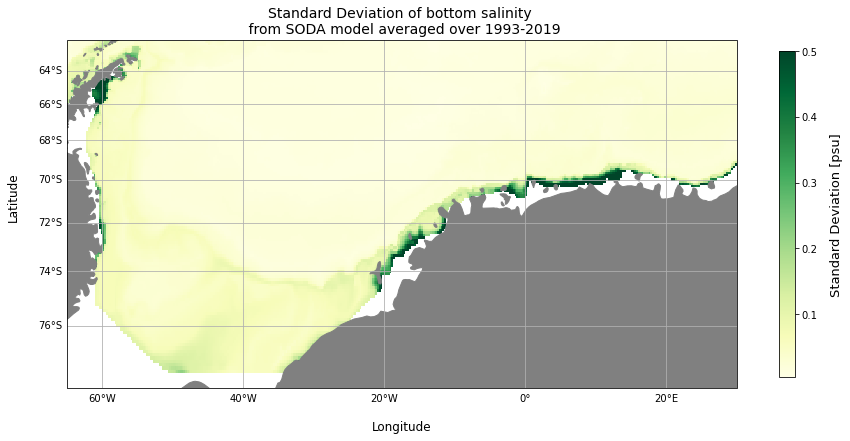

In [63]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ds_wg.xt_ocean, ds_wg.yt_ocean, bottom_salt_std, transform=ccrs.PlateCarree(), cmap='YlGn', vmax=0.5)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation of bottom salinity \n from SODA model averaged over 1993-2019', fontsize=14);

In [108]:
swap_dim_slt = bottom_salt_std.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})

In [109]:
bottom_salt_std = swap_dim_slt.assign_coords({"lon": swap_dim_slt.lon, 'lat':swap_dim_slt.lat}).drop(['xt_ocean', 'yt_ocean'])

In [110]:
bottom_salt_std

<xarray.DataArray 'salt' (lat: 169, lon: 381)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.01667607, 0.0167114 , 0.016342  , ..., 0.01590053, 0.01613886,
        0.01642593],
       [0.01640019, 0.01632544, 0.01374952, ..., 0.01542513, 0.01547884,
        0.01569463],
       [0.01606008, 0.01450908, 0.01440152, ..., 0.0149381 , 0.01464861,
        0.01431615]], dtype=float32)
Coordinates:
    st_ocean  (lat, lon) float64 5.395e+03 5.395e+03 ... 5.185e+03 5.185e+03
    time      object 1993-01-04 13:00:00
  * lon       (lon) int64 0 1 2 3 4 5 6 7 8 ... 373 374 375 376 377 378 379 380
  * lat       (lat) int64 0 1 2 3 4 5 6 7 8 ... 161 162 163 164 165 166 167 168

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)